In [5]:
import botorch
from known_boundary.acquisition_function import EI_acquisition_opt,MES_acquisition_opt,LCB_acquisition_opt,ERM_acquisition_opt,SLogTEI_acquisition_opt,SLogEI_acquisition_opt
from known_boundary.utlis import  get_initial_points,transform,opt_model_MLE,opt_model_MAP
import numpy as np
import GPy
import torch
from botorch.test_functions import Ackley,Levy,Beale,Branin,Rosenbrock,SixHumpCamel,Hartmann,Powell,StyblinskiTang
import obj_functions.push_problems
from botorch.utils.transforms import unnormalize,normalize
from known_boundary.SLogGP import SLogGP
import scipy 
from obj_functions import obj_function

import warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger('lengthscale').disabled = True
logging.getLogger('variance').disabled = True
logging.getLogger('psi').disabled = True


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double

In [3]:
standard_bounds =np.array([0.,1.]*6).reshape(-1,2) 
n_init = 4*6
iter_num = 30
N = 20

step_size=1
lengthscale_range = [0.001,2]
variance_range = [0.001**2,4**2]
noise = 1e-6

In [4]:
BO_EI = []

for exp in range(N):
    
    print(exp)

    seed = exp

    fun = obj_function.XGBoost(task='bank', seed=seed)

    dim = fun.dim
    bounds = fun.bounds
    
    fstar = 0.
    

    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)
    
    best_record = [Y_BO.min().item()]
    
    init_best = Y_BO.min().item()
    
    np.random.seed(1234)

    for i in range(iter_num):

        print(i)
    
        train_Y = (Y_BO - Y_BO.mean()) / Y_BO.std()
        train_X = normalize(X_BO, bounds)
        
        minimal = train_Y.min().item()
        
        train_Y = train_Y.numpy()
        train_X = train_X.numpy()
        
        # train the GP
        if i%step_size == 0:
            
            parameters = opt_model_MLE(train_X,train_Y,dim,'GP',noise=noise,seed=i,lengthscale_range=lengthscale_range,variance_range=variance_range)
                
            lengthscale = parameters[0]
            variance = parameters[1]
            
            # print('lengthscale: ',lengthscale)
            # print('variance: ',variance)
            
        kernel = GPy.kern.RBF(input_dim=dim,lengthscale=lengthscale,variance=variance)
        m = GPy.models.GPRegression(train_X.reshape(-1,dim), train_Y.reshape(-1,1),kernel)
        m.Gaussian_noise.fix(noise)

        np.random.seed(i)
        standard_next_X = EI_acquisition_opt(m,bounds=standard_bounds,f_best=minimal)
        X_next = unnormalize(torch.tensor(standard_next_X), bounds).reshape(-1,dim)            
        Y_next = fun(X_next).reshape(-1,1)

        # Append data
        X_BO = torch.cat((X_BO, X_next), dim=0)
        Y_BO = torch.cat((Y_BO, Y_next), dim=0)
        
        best_record.append(Y_BO.min().item())
        
        print(best_record[-1])
        
        noise = variance*10**(-5)   #adaptive noise
        noise = np.round(noise, -int(np.floor(np.log10(noise))))
        print('noise: ',noise)
        
    best_record = np.array(best_record) 
    BO_EI.append(best_record)

0
0
4.540008557980329
noise:  1e-05
1
4.540008557980329
noise:  9e-06
2
4.459036898061285
noise:  8e-06
3
4.459036898061285
noise:  8e-06
4
3.9715611731016054
noise:  7e-06
5
2.836970474967899
noise:  7e-06
6
2.2695105493564967
noise:  7e-06
7
2.2695105493564967
noise:  7e-06
8
2.2695105493564967
noise:  7e-06
9
2.2695105493564967
noise:  7e-06
10
2.1088838418748708
noise:  7e-06
11
2.1088838418748708
noise:  7e-06
12
2.1088838418748708
noise:  6e-06
13
2.027912181955813
noise:  7e-06
14
2.027912181955813
noise:  7e-06
15
2.027912181955813
noise:  7e-06
16
2.027912181955813
noise:  6e-06
17
2.027912181955813
noise:  6e-06
18
2.027912181955813
noise:  6e-06
19
2.027912181955813
noise:  7e-06
20
2.027912181955813
noise:  7e-06
21
2.027912181955813
noise:  7e-06
22
2.027912181955813
noise:  7e-06
23
2.027912181955813
noise:  7e-06
24
2.027912181955813
noise:  7e-06
25
2.027912181955813
noise:  7e-06
26
2.027912181955813
noise:  7e-06
27
2.027912181955813
noise:  7e-06
28
2.027912181955813

SlogGP+logEI

In [20]:
LogEI_noboundary = []

for exp in range(N):
    
    print(exp)

    seed = exp

    fun = obj_function.XGBoost(task='bank', seed=seed)

    dim = fun.dim
    bounds = fun.bounds
    
    fstar = 0.
    

    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)
    
    best_record = [Y_BO.min().item()]
    
    init_best = Y_BO.min().item()
    
    np.random.seed(1234)
    
    for i in range(iter_num):

            print('inner loop: ',i)
    
            train_Y = Y_BO.numpy()
            train_X = normalize(X_BO, bounds)
            train_X = train_X.numpy()
        
            train_Y_std = np.std(train_Y)
            lower = -np.min(train_Y)+10**(-6)
            upper = lower+2000 #min(300,5*train_Y_std)
        
            c_range = [lower,upper]

            if i%step_size == 0:
            
                parameters = opt_model_MLE(train_X,train_Y,dim,'SLogGP',noise=noise,seed=i,lengthscale_range=lengthscale_range,variance_range=variance_range,c_range=c_range)                

                lengthscale = parameters[0]
                variance = parameters[1]
                c = parameters[2]
            
                # print('lengthscale is ',lengthscale)
                # print('variance is ',variance)
                print('lower bound is ',-c)
        
        
            warp_Y = np.log(train_Y+c)
            mean_warp_Y = np.mean(warp_Y) # use to predict mean
            warp_Y_standard = warp_Y-mean_warp_Y
        
        
            kernel = GPy.kern.RBF(input_dim=dim,lengthscale= lengthscale,variance=variance)  
            m = GPy.models.GPRegression(train_X, warp_Y_standard,kernel)
            m.Gaussian_noise.variance.fix(noise)
        
            np.random.seed(i)
            standard_next_X = SLogEI_acquisition_opt(model=m,bounds=standard_bounds,f_best=np.min(train_Y),c=c,f_mean=mean_warp_Y)
            X_next = unnormalize(torch.tensor(standard_next_X), bounds).reshape(-1,dim)            
            Y_next = fun(X_next).reshape(-1,1)

            # Append data
            X_BO = torch.cat((X_BO, X_next), dim=0)
            Y_BO = torch.cat((Y_BO, Y_next), dim=0)
        
            best_record.append(Y_BO.min().item())
            print(best_record[-1])
        
            noise = variance*10**(-5)   #adaptive noise
            noise = np.round(noise, -int(np.floor(np.log10(noise))))
            print('noise: ',noise)
        
        
    best_record = np.array(best_record)         
    LogEI_noboundary.append(best_record)

0
inner loop:  0
lower bound is  -1205.531844685927
4.540008557980329
noise:  1e-10
inner loop:  1
lower bound is  -23.629661475649616
4.540008557980329
noise:  1e-07
inner loop:  2
lower bound is  -1995.4599888053776
3.647674533425487
noise:  3e-11
inner loop:  3
lower bound is  -512.0513118829654
3.647674533425487
noise:  5e-10
inner loop:  4
lower bound is  -1996.352326466495
3.322800434482076
noise:  3e-11
inner loop:  5
lower bound is  -49.76560367879851
3.322800434482076
noise:  4e-08
inner loop:  6
lower bound is  -37.636272541657775
3.322800434482076
noise:  6e-08
inner loop:  7
lower bound is  -18.491307780724195
3.322800434482076
noise:  2e-07
inner loop:  8
lower bound is  -9.550643648542923
3.1605279615549193
noise:  3e-07
inner loop:  9
lower bound is  -6.3566542407725715
3.1605279615549193
noise:  5e-07
inner loop:  10
lower bound is  -3.870544698189306
3.1605279615549193
noise:  7e-07
inner loop:  11
lower bound is  -2.732952707921643
3.1605279615549193
noise:  9e-07
inn

# SlogGP+logEI(with boundary)

In [22]:
LogEI_boundary = []

for exp in range(N):
    
    print(exp)

    seed = exp

    fun = obj_function.XGBoost(task='bank', seed=seed)

    dim = fun.dim
    bounds = fun.bounds
    
    fstar = 0.
    

    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)
    
    best_record = [Y_BO.min().item()]
    
    init_best = Y_BO.min().item()
    
    np.random.seed(1234)
    
    
    uncertainty_index = 1
    tolerance_level = 2.5
        
        
    for i in range(iter_num):

            print('inner loop: ',i)
            print('uncertainty: ',uncertainty_index)
        
            train_Y = Y_BO.numpy()
            fstar_shifted = fstar - np.min(train_Y)  # shifted lower bound

            train_Y = train_Y - np.min(train_Y)  # shift Y

            train_X = normalize(X_BO, bounds)
            train_X = train_X.numpy()
            
            lower = -np.min(train_Y)+10**(-6)
            upper = lower+2000 
            c_range = [lower,upper]
            
            mu_prior = np.log(-fstar_shifted)  #np.log(-fstar_shifted+ 0.3)  
            sigma_prior = 0.25*uncertainty_index       #np.sqrt(np.log(-fstar_shifted+0.3)-np.log(-fstar_shifted))
            prior_parameter = [mu_prior,sigma_prior]
            

            if i%step_size == 0:
                
                if uncertainty_index<=25:
                
                    best_parameter = opt_model_MAP(train_X,train_Y,dim,lengthscale_range,variance_range,prior_parameter,noise=noise,seed=i)
        
                    lengthscale = best_parameter[0]
                    variance = best_parameter[1]
                    c = best_parameter[2]
                    
                    print('-c: ',-c)
                    
                    if abs(-c-fstar_shifted)> np.exp(mu_prior+tolerance_level*sigma_prior) -np.exp(mu_prior): #      100
                        temp = (np.log(abs(-c-fstar_shifted)+np.exp(mu_prior))-mu_prior)/sigma_prior - tolerance_level
                        uncertainty_index += 2*temp
                    
                        print('Not Use prior')
                        parameters = opt_model_MLE(train_X,train_Y,dim,'SLogGP',noise=noise,seed=i,lengthscale_range=lengthscale_range,variance_range=variance_range,c_range=c_range)                
        
                        lengthscale = parameters[0]
                        variance = parameters[1]
                        c = parameters[2]
                else: 
                    print('Not Use prior because uncertainty is huge')
                    parameters = opt_model_MLE(train_X,train_Y,dim,'SLogGP',noise=noise,seed=i,lengthscale_range=lengthscale_range,variance_range=variance_range,c_range=c_range)                
    
                    lengthscale = parameters[0]
                    variance = parameters[1]
                    c = parameters[2]
                
                
                # print('lengthscale: ',lengthscale)
                # print('variance: ',variance)
                # print('lower bound: ',-c+np.min(train_Y))
                # print('shift fstar: ',fstar_shifted)
            
            
            warp_Y = np.log(train_Y+c)
            mean_warp_Y = np.mean(warp_Y) # use to predict mean
            warp_Y_standard = warp_Y-mean_warp_Y
            
            
            kernel = GPy.kern.RBF(input_dim=dim,lengthscale= lengthscale,variance=variance)  
            m = GPy.models.GPRegression(train_X, warp_Y_standard,kernel)
            m.Gaussian_noise.variance.fix(noise)
            
            np.random.seed(i)
            standard_next_X = SLogEI_acquisition_opt(model=m,bounds=standard_bounds,f_best=np.min(train_Y),c=c,f_mean=mean_warp_Y)
            X_next = unnormalize(torch.tensor(standard_next_X), bounds).reshape(-1,dim)            
            Y_next = fun(X_next).reshape(-1,1)
            

            # Append data
            X_BO = torch.cat((X_BO, X_next), dim=0)
            Y_BO = torch.cat((Y_BO, Y_next), dim=0)
            
            best_record.append(Y_BO.min().item())
            print('best so far: ',best_record[-1])
            
            noise = variance*10**(-5)   #adaptive noise
            noise = np.round(noise, -int(np.floor(np.log10(noise))))
            #print('noise: ',noise)
            
            
    best_record = np.array(best_record)     
    LogEI_boundary.append(best_record)

0
inner loop:  0
uncertainty:  1
-c:  -4.518535172478091
best so far:  4.540008557980329
inner loop:  1
uncertainty:  1
-c:  -4.477184520823138
best so far:  4.540008557980329
inner loop:  2
uncertainty:  1
-c:  -4.719561926385383
best so far:  4.133833646028776
inner loop:  3
uncertainty:  1
-c:  -35.086170176769116
Not Use prior
best so far:  4.133833646028776
inner loop:  4
uncertainty:  13.108814566072272
-c:  -33.91721747007682
best so far:  4.1335044929396645
inner loop:  5
uncertainty:  13.108814566072272
-c:  -2005.0289432193235
best so far:  4.1335044929396645
inner loop:  6
uncertainty:  13.108814566072272
-c:  -2.4349566978992714
best so far:  3.9715611731016054
inner loop:  7
uncertainty:  13.108814566072272
-c:  -1.5295938951802115
best so far:  3.9715611731016054
inner loop:  8
uncertainty:  13.108814566072272
-c:  -2.162947619092862
best so far:  3.2421579276521584
inner loop:  9
uncertainty:  13.108814566072272
-c:  -4.539529521550253
best so far:  3.2421579276521584
in

# SlogGP+logTEI

In [4]:
LogTEI_boundary = []

for exp in range(N):
    
    exp = 21
    
    print(exp)

    seed = exp

    fun = obj_function.XGBoost(task='bank', seed=seed)

    dim = fun.dim
    bounds = fun.bounds
    
    fstar = 0.
    

    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)
    
    best_record = [Y_BO.min().item()]
    
    init_best = Y_BO.min().item()
    
    np.random.seed(1234)
    
    
    uncertainty_index = 1
    tolerance_level = 2.5
        

    for i in range(iter_num):

            print('inner loop: ',i)
            print('uncertainty: ',uncertainty_index)
        
            train_Y = Y_BO.numpy()
            fstar_shifted = fstar - np.min(train_Y)  # shifted lower bound

            train_Y = train_Y - np.min(train_Y)  # shift Y

            train_X = normalize(X_BO, bounds)
            train_X = train_X.numpy()
            
            lower = -np.min(train_Y)+10**(-6)
            upper = lower+2000 
            c_range = [lower,upper]
            
            mu_prior = np.log(-fstar_shifted)  #np.log(-fstar_shifted+ 0.3)  
            sigma_prior = 0.25*uncertainty_index       #np.sqrt(np.log(-fstar_shifted+0.3)-np.log(-fstar_shifted))
            prior_parameter = [mu_prior,sigma_prior]
            

            if i%step_size == 0:
                
                if uncertainty_index<=25:
                    #print('MAP')
                
                    best_parameter = opt_model_MAP(train_X,train_Y,dim,lengthscale_range,variance_range,prior_parameter,noise=noise,seed=i)
        
                    lengthscale = best_parameter[0]
                    variance = best_parameter[1]
                    c = best_parameter[2]
                    
                    print('-c: ',-c)
                    
                    if abs(-c-fstar_shifted)> np.exp(mu_prior+tolerance_level*sigma_prior) -np.exp(mu_prior): #      100
                        temp = (np.log(abs(-c-fstar_shifted)+np.exp(mu_prior))-mu_prior)/sigma_prior - tolerance_level
                        uncertainty_index += 2*temp
                    
                        print('Not Use prior')
                        parameters = opt_model_MLE(train_X,train_Y,dim,'SLogGP',noise=noise,seed=i,lengthscale_range=lengthscale_range,variance_range=variance_range,c_range=c_range)                
        
                        lengthscale = parameters[0]
                        variance = parameters[1]
                        c = parameters[2]
                else: 
                    #print('MLE')
                    print('Not Use prior because uncertainty is huge')
                    parameters = opt_model_MLE(train_X,train_Y,dim,'SLogGP',noise=noise,seed=i,lengthscale_range=lengthscale_range,variance_range=variance_range,c_range=c_range)                
    
                    lengthscale = parameters[0]
                    variance = parameters[1]
                    c = parameters[2]
                
                
                # print('lengthscale: ',lengthscale)
                # print('variance: ',variance)
                # print('lower bound: ',-c+np.min(train_Y))
                # print('shift fstar: ',fstar_shifted)
            
            
            warp_Y = np.log(train_Y+c)
            mean_warp_Y = np.mean(warp_Y) # use to predict mean
            warp_Y_standard = warp_Y-mean_warp_Y
            
            
            kernel = GPy.kern.RBF(input_dim=dim,lengthscale= lengthscale,variance=variance)  
            m = GPy.models.GPRegression(train_X, warp_Y_standard,kernel)
            m.Gaussian_noise.variance.fix(noise)
            
            np.random.seed(i)
            if -c>=fstar_shifted:
                print('logEI')
                standard_next_X = SLogEI_acquisition_opt(model=m,bounds=standard_bounds,f_best=np.min(train_Y),c=c,f_mean=mean_warp_Y)
            else:
                print('logTEI')
                standard_next_X = SLogTEI_acquisition_opt(model=m,bounds=standard_bounds,f_best=np.min(train_Y),c=c,f_mean=mean_warp_Y,fstar=fstar_shifted)  
            
            X_next = unnormalize(torch.tensor(standard_next_X), bounds).reshape(-1,dim)            
            Y_next = fun(X_next).reshape(-1,1)
            

            # Append data
            X_BO = torch.cat((X_BO, X_next), dim=0)
            Y_BO = torch.cat((Y_BO, Y_next), dim=0)
            
            best_record.append(Y_BO.min().item())
            print('best so far: ',best_record[-1])
            
            noise = variance*10**(-5)   #adaptive noise
            noise = np.round(noise, -int(np.floor(np.log10(noise))))
            #print('noise: ',noise)
            
            
    best_record = np.array(best_record)     
    LogTEI_boundary.append(best_record)

21
inner loop:  0
uncertainty:  1
-c:  -5.049514188104036
logTEI
best so far:  4.6989895000164665
inner loop:  1
uncertainty:  1
-c:  -4.858287081535031
logTEI
best so far:  4.6989895000164665
inner loop:  2
uncertainty:  1
-c:  -1420.6922449025935
Not Use prior
logTEI
best so far:  4.6989895000164665
inner loop:  3
uncertainty:  41.69241634091287
Not Use prior because uncertainty is huge
logTEI
best so far:  4.617688687008339
inner loop:  4
uncertainty:  41.69241634091287
Not Use prior because uncertainty is huge
logTEI
best so far:  4.617688687008339
inner loop:  5
uncertainty:  41.69241634091287
Not Use prior because uncertainty is huge
logTEI
best so far:  4.617688687008339
inner loop:  6
uncertainty:  41.69241634091287
Not Use prior because uncertainty is huge
logTEI
best so far:  4.617688687008339
inner loop:  7
uncertainty:  41.69241634091287
Not Use prior because uncertainty is huge
logTEI
best so far:  4.617688687008339
inner loop:  8
uncertainty:  41.69241634091287
Not Use pr

KeyboardInterrupt: 

In [6]:
import numpy as np
import os
import matplotlib.pyplot as plt

def log_RegretMean_plot(res,fstar,label,color,linestyle,error_bound=True):
    
    
    total_record = (np.array(res)-fstar)
    
    N = total_record.shape[0]
    
    std = np.std(total_record,axis=0)
    
    mean = np.mean(total_record,axis=0)
    
    iter = np.array(range(mean.shape[0]))
    
    lower = mean - 1*std/np.sqrt(N)
    upper = mean + 1*std/np.sqrt(N)
    
    lower.astype(float)
    upper.astype(float)
    
    
    plt.plot(mean,linewidth=2,label=label,color=color,linestyle=linestyle)
    if error_bound:
        plt.fill_between(iter, lower, upper,alpha=0.25,color=color)
    
    #plt.yscale("log")  

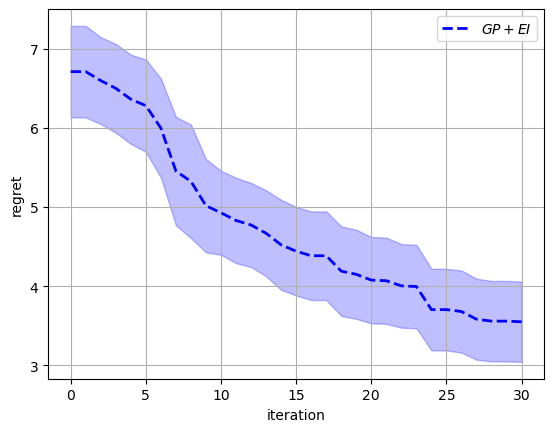

In [8]:
log_RegretMean_plot(BO_EI,fstar=fstar,label='$GP+EI$',color='blue',linestyle='dashed',error_bound=True)
# log_RegretMean_plot(LogEI_noboundary,fstar=fstar,label='$SlogGP+logEI$',color='red',linestyle='dashed',error_bound=True)
# log_RegretMean_plot(LogEI_boundary,fstar=fstar,label='$SlogGP^b+logEI$',color='green',linestyle='-',error_bound=True)
# log_RegretMean_plot(LogTEI_boundary,fstar=fstar,label='$SlogGP^b+logTEI$',color='black',linestyle='-',error_bound=True)

plt.xlabel('iteration')
plt.ylabel('regret')

plt.grid()

plt.legend()

Text(0.5, 1.0, 'Bank')

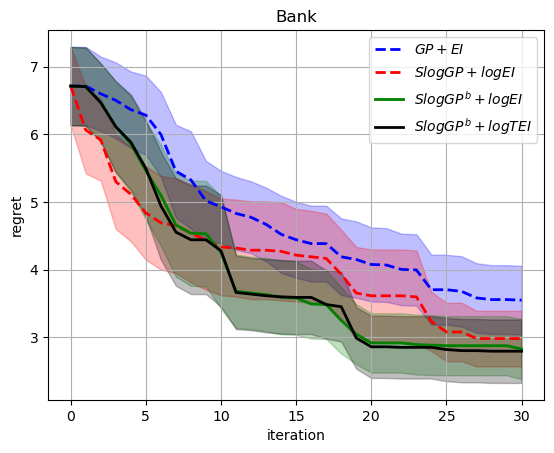

In [18]:
log_RegretMean_plot(BO_EI,fstar=fstar,label='$GP+EI$',color='blue',linestyle='dashed',error_bound=True)
log_RegretMean_plot(LogEI_noboundary,fstar=fstar,label='$SlogGP+logEI$',color='red',linestyle='dashed',error_bound=True)
log_RegretMean_plot(LogEI_boundary,fstar=fstar,label='$SlogGP^b+logEI$',color='green',linestyle='-',error_bound=True)
log_RegretMean_plot(LogTEI_boundary,fstar=fstar,label='$SlogGP^b+logTEI$',color='black',linestyle='-',error_bound=True)

plt.xlabel('iteration')
plt.ylabel('regret')

plt.grid()

plt.legend()
plt.title('Bank')

Text(0.5, 1.0, 'Bank')

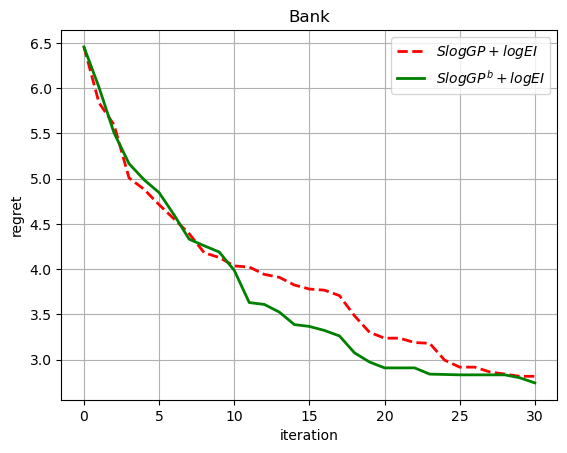

In [25]:
#log_RegretMean_plot(BO_EI,fstar=fstar,label='$GP+EI$',color='blue',linestyle='dashed',error_bound=True)
log_RegretMean_plot(LogEI_noboundary,fstar=fstar,label='$SlogGP+logEI$',color='red',linestyle='dashed',error_bound=False)
log_RegretMean_plot(LogEI_boundary,fstar=fstar,label='$SlogGP^b+logEI$',color='green',linestyle='-',error_bound=False)
#log_RegretMean_plot(LogTEI_boundary,fstar=fstar,label='$SlogGP^b+logTEI$',color='black',linestyle='-',error_bound=True)

plt.xlabel('iteration')
plt.ylabel('regret')

plt.grid()

plt.legend()
plt.title('Bank')